In [1]:
# Importing relevant ibraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_original = pd.read_csv('bank_marketing.csv')
data_original.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


We'll be modeling KNN classifiers on a revised dataset,
**by Dropping 'default' column from original dataset**

In [3]:
# Revised dataset: Dropping 'default' column from original dataset
data_revised_1 = data_original.copy()
data_revised_1.drop('default', axis=1, inplace=True)
data_revised_1.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


**This dataset has an Imbalanced Target Class. In the 'y' column, there are 88% observations with label 'no' and ONLY 12% observations with label 'yes'. <br/>
Machine learning algorithms have trouble learning when one class dominates the other in the target variable. And so before we train any ML model on this dataset we need to balance it appropriately.**

To over-sample minority class we would use two popular methods: SMOTE and ROSE.
But before we try it out, let's ensure that we split our dataset in such a way that the observations in over-sampled training set are in no way related to observations in our test set. To do this, we do a two-level split.
1. In the 1st split we divide our entire data into train_1 and test_1 set
2. We further divide our train_1 set into train_2 and val set
3. We use the methods SMOTE and ROSE to over-sample our train_2 set.
4. We train our ML algorithms on over-sampled train_2 set that we generate from step 3.
5. Finally, we test our ML algorithms on test_1 set.

Thus, we ensure that the ML algorithms (trained on over-sampled train_2 set) ARE NOT BIASED towards observations from test_1 set and thus DO NOT OVERFIT.

In [4]:
# Importing relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# First, convert all columns into numeric variables
variables_set = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

# One Hot Encoding: All categorical columns/variables in the dataset must be encoded as numeric values.
# For dataset 1
one_hot_encoded_job       = pd.get_dummies(data_revised_1['job'])
one_hot_encoded_marital   = pd.get_dummies(data_revised_1['marital'])
one_hot_encoded_education = pd.get_dummies(data_revised_1['education'])
one_hot_encoded_housing   = pd.get_dummies(data_revised_1['housing'])
one_hot_encoded_loan      = pd.get_dummies(data_revised_1['loan'])
one_hot_encoded_contact   = pd.get_dummies(data_revised_1['contact'])
one_hot_encoded_month     = pd.get_dummies(data_revised_1['month'])
one_hot_encoded_poutcome  = pd.get_dummies(data_revised_1['poutcome'])

data_revised_1_converted = data_revised_1[variables_set]

data_revised_1_converted = pd.concat([data_revised_1_converted,
                                      one_hot_encoded_job, 
                                      one_hot_encoded_marital, 
                                      one_hot_encoded_education,
                                      one_hot_encoded_housing,
                                      one_hot_encoded_loan,
                                      one_hot_encoded_contact,
                                      one_hot_encoded_month,
                                      one_hot_encoded_poutcome], axis = 1)

# From the 1st dataset, create a training set and a test set
data_revised_1_X_train, data_revised_1_X_test, \
data_revised_1_y_train, data_revised_1_y_test = train_test_split(data_revised_1_converted.drop('y', axis=1),
                                                                 data_revised_1_converted.y, 
                                                                 test_size=.1,       # Training set = 90%, Test set = 10%
                                                                 random_state=12)

# Use the training set to create another set of training and validation set
X1_train, X1_val, y1_train, y1_val = train_test_split(data_revised_1_X_train, data_revised_1_y_train,
                                                      test_size = .1,
                                                      random_state=12)

## Handling Imbalanced Classes

### Method 1 - SMOTE (Synthetic Minority Over-sampling TEchnique)

SMOTE draws artificial samples by choosing points that lie on the line connecting the rare observation to one of its nearest neighbors in the feature space.

In [5]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to over-sample this training set
sm = SMOTE(random_state=12, ratio = 1.0)
X1_train_res_sm, y1_train_res_sm = sm.fit_sample(X1_train, y1_train)

Before proceeding to Hyper-parameter tuning let's build a function that can help us test the accuracy of our models.

In [6]:
def model_fit(alg, print_FeatureImportance=True):
    
    # Test the model on the test set
    data_revised_1_X_test_predictions = alg.predict(data_revised_1_X_test)
    data_revised_1_X_test_predprob    = alg.predict_proba(data_revised_1_X_test)[:,1]
    
    # Perform Cross-Validation
    cv_score_acc = cross_validate(alg, data_revised_1_X_test, data_revised_1_y_test, cv=10, scoring='accuracy')
    cv_score_auc_roc = cross_validate(alg, data_revised_1_X_test, data_revised_1_y_test, cv=10, scoring='roc_auc')
        
    # Print Model report
    print('\nPerformance on Test Set')
    print('1. Mean cross-validated score (AUC_ROC) of the best_estimator: %.7g' % (np.mean(cv_score_auc_roc['test_score'])))
    print('2. Mean cross-validated score (accuracy) of the best_estimator: %.7g' % (np.mean(cv_score_acc['test_score'])))
          
    # Print Feature Importances
    predictors = data_revised_1_converted.drop('y', axis=1).columns
    if print_FeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importance')
        plt.ylabel('Feature Importance Score')

#### Building KNN Classifier using GridSearchCV

In [44]:
# Importing relevant libraries
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


# Set a range for hyper-parameters
k_range = list(range(3,7))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')
grid.fit(X1_train_res_sm, y1_train_res_sm)

# Print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid.best_score_)
print('2. Parameter setting that gave the best results:', grid.best_params_)
print('3. Estimator which gave highest score:', grid.best_estimator_)

# Train the best estimator on the train set
knn_clf_sm = grid.best_estimator_.fit(X1_train_res_sm, y1_train_res_sm)

model_fit(knn_clf_sm, print_FeatureImportance=False)


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9357621
2. Parameter setting that gave the best results: {'n_neighbors': 6, 'weights': 'distance'}
3. Estimator which gave highest score: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.6633301
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8655951


### Method 2 - ROSE (Random Over-Sampling Examples)

ROSE uses random replication of samples from the feature space neighbourhood around the minority class.

In [8]:
# Import ROSE library
from imblearn.over_sampling import RandomOverSampler

# Use Random Over-Sampling to over-sample this training set
ros = RandomOverSampler(random_state=12)
X1_train_res_ros, y1_train_res_ros = ros.fit_sample(X1_train, y1_train)

#### KNN Classifier using GridSearchCV

In [9]:
# Set a range for hyper-parameters
k_range = list(range(1,19))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')
grid.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator\n', grid.best_score_)
print('2. Parameter setting that gave the best results\n', grid.best_params_)
print('3. Estimator which gave highest score\n', grid.best_estimator_)

#Train the best estimator on the train set
knn_clf_ros = grid.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

# Test the best estimator on the test set
model_fit(knn_clf_ros, print_FeatureImportance=False)


Model Performance on Train Set
Mean cross-validated score (roc_auc) of the best_estimator
 0.9934049079754601
Parameter setting that gave the best results
 {'n_neighbors': 18, 'weights': 'distance'}
Estimator which gave highest score
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=18, p=2,
           weights='distance')

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.6868205
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8786847


**After evaluating the two different methods of handling imbalanced classes SMOTE and ROSE, what we could see is ROSE (Random Over-Sampling Examples) shows better prediction accuracy for KNN Classification Algorithm on this dataset.**

#### Building Gradient Boosting Trees Model

In [10]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection import cross_validate  #Additional scklearn functions

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

##### GBM_CLF_0

Performance of "glb_clf_0"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8716763
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8854018


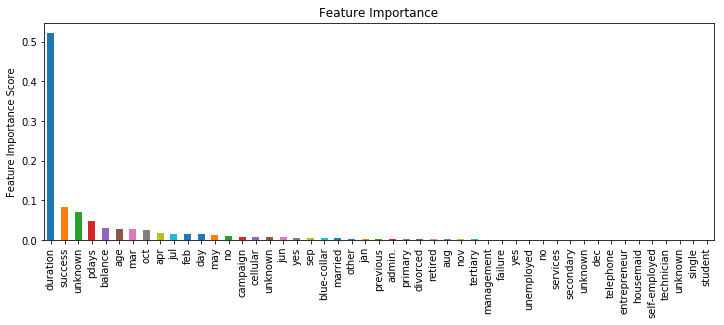

In [11]:
# Create a baseline model
gbm0 = GradientBoostingClassifier(random_state=10)
gbm_clf_0 = gbm0.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_0"')
model_fit(gbm_clf_0, print_FeatureImportance=True)

So, the **mean CV Accuracy score is 0.8854018** and we should expect our model to do better than this.

#### Approach towards Parameter Tuning

There are two types of hyper-parameters to be tuned here:
1. Tree-based parameters
2. Boosting parameters

There are no optimum values for learning rate as low values always work better, given that we train on sufficient number of trees.

**Approach:**
1. Choose a **relatively high learning rate**. 
2. Determine the optimum number of trees for this learning rate.
3. Tune tree-specific parameters for decided learning rate and number of trees. 
4. Lower the learning rate and increase the estimators proportionally to get more robust models.

**Fix learning rate and number of estimators for tuning tree-based parameters:**
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1. **min_samples_split = 80** : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
2. **min_samples_leaf = 20** : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
3. **max_depth = 4** : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
4. **max_features = ‘sqrt’** : Its a general thumb-rule to start with square root.
5. **subsample = 0.8** : This is a commonly used start value

Took the default learning rate of 0.1 here and checked the optimum number of trees for that. For this purpose, we did a grid search and tested out values from 20 to 80 in steps of 10.

##### GBM_CLF_1


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9447006
2. Parameter setting that gave the best results: {'n_estimators': 80}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=80,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_1"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8336795
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8812473


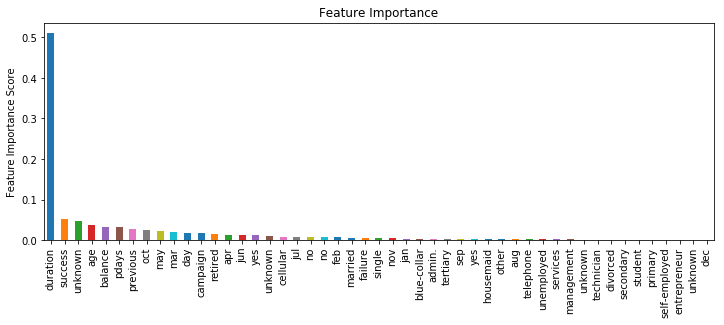

In [52]:
# Choose all predictors variables
predictors = data_revised_1_converted.drop('y', axis=1).columns

# Assign the test parameter i.e. # Max number of Trees
param_grid1 = {'n_estimators':range(20,81,10)}
grid1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=80,
                                                               min_samples_leaf=20,
                                                               max_depth=4,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10),
                     param_grid = param_grid1,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid1.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid1.best_score_)
print('2. Parameter setting that gave the best results:', grid1.best_params_)
print('3. Estimator which gave highest score:\n', grid1.best_estimator_)

# Assign a name to the best estimator on the train set
gbm_clf_1 = grid1.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_1"')
model_fit(gbm_clf_1, print_FeatureImportance=True)

For the assigned range, we got 80 as the optimal number of estimators for 0.1 learning rate.

Tuning tree-specific parameters:
The following order is followed in tuning tree-specific parameters.

1. Max_depth 
2. Min_samples_split
2. Min_samples_leaf
3. Max_features

##### GBM_CLF_2


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9690777
2. Parameter setting that gave the best results: {'max_depth': 6, 'min_samples_split': 40}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=40,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_2"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8423846
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8812978


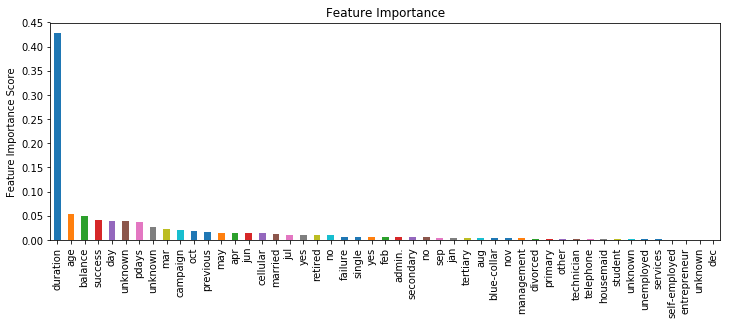

In [53]:
# Assign the test parameters i.e. # Max Depth and # Min Samples at Split 
param_grid2 = {'max_depth':range(2,8,2), 'min_samples_split':range(40,200,20)}
grid2 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=80,
                                                          min_samples_leaf=20,
                                                          max_features='sqrt',
                                                          subsample=0.8,
                                                          random_state=10),
                     param_grid = param_grid2,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid2.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid2.best_score_)
print('2. Parameter setting that gave the best results:', grid2.best_params_)
print('3. Estimator which gave highest score:\n', grid2.best_estimator_)

# Assign a model name to the best estimator on the train set
gbm_clf_2 = grid2.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_2"')
model_fit(gbm_clf_2, print_FeatureImportance=True)

We get an optimum max tree depth of 6, however we can still check for lower values of min_samples_split.

##### GBM_CLF_3


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9739047
2. Parameter setting that gave the best results: {'min_samples_leaf': 10, 'min_samples_split': 30}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=30,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_3"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8408654
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8832762


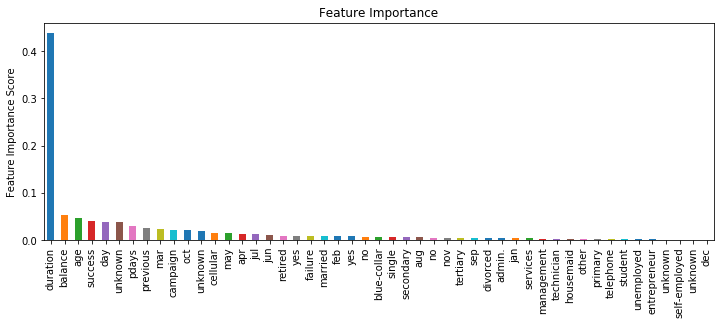

In [54]:
# Assign the test parameters i.e. # Min Samples at Split and # Min Samples at Leaf
param_grid3 = {'min_samples_leaf':range(10,40,10), 'min_samples_split':range(20,60,10)}
grid3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=80,
                                                          max_depth=6,
                                                          max_features='sqrt',
                                                          subsample=0.8,
                                                          random_state=10),
                     param_grid = param_grid3,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid3.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid3.best_score_)
print('2. Parameter setting that gave the best results:', grid3.best_params_)
print('3. Estimator which gave highest score:\n', grid3.best_estimator_)

# Assign a model name to the best estimator on the train set
gbm_clf_3 = grid3.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_3"')
model_fit(gbm_clf_3, print_FeatureImportance=True)

##### GBM_CLF_4


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9755843
2. Parameter setting that gave the best results: {'min_samples_leaf': 3}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=30,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_4"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8476282
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8941458


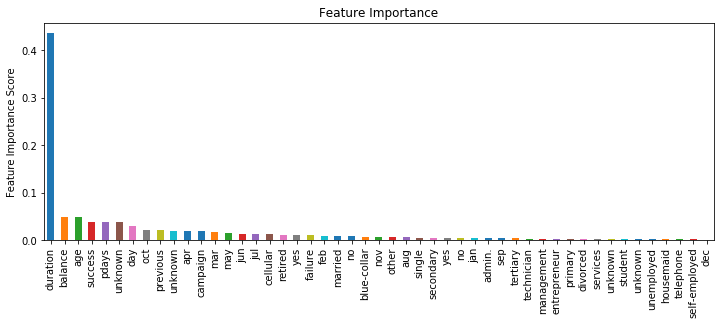

In [55]:
# Assign the test parameters i.e. # Min Samples at Leaf
param_grid4 = {'min_samples_leaf':range(2,10,1)}
grid4 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=80,
                                                          min_samples_split=30,
                                                          max_depth=6,
                                                          max_features='sqrt',
                                                          subsample=0.8,
                                                          random_state=10),
                     param_grid = param_grid4,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid4.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid4.best_score_)
print('2. Parameter setting that gave the best results:', grid4.best_params_)
print('3. Estimator which gave highest score:\n', grid4.best_estimator_)

# Assign a model name to the best estimator on the train set
gbm_clf_4 = grid4.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_4"')
model_fit(gbm_clf_4, print_FeatureImportance=True)

##### GBM_CLF_5


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9818322
2. Parameter setting that gave the best results: {'max_features': 19}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=19, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=30,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_5"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.86425
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8854018


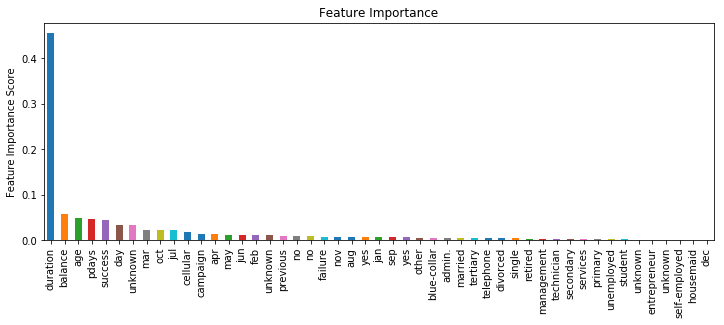

In [56]:
# Assign the test parameters i.e. # Max Features
param_grid5 = {'max_features':range(7,20,2)}
grid5 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=80,
                                                          max_depth=6,
                                                          min_samples_split=30,
                                                          min_samples_leaf=3,
                                                          subsample=0.8,
                                                          random_state=10),
                     param_grid = param_grid5,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid5.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid5.best_score_)
print('2. Parameter setting that gave the best results:', grid5.best_params_)
print('3. Estimator which gave highest score:\n', grid5.best_estimator_)

# Assign a model name to the best estimator on the train set
gbm_clf_5 = grid5.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_5"')
model_fit(gbm_clf_5, print_FeatureImportance=True)

##### GBM_CLF_6

C:\Users\visha\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9835363
2. Parameter setting that gave the best results: {'max_features': 29}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=29, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=30,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_6"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8709038
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8876241


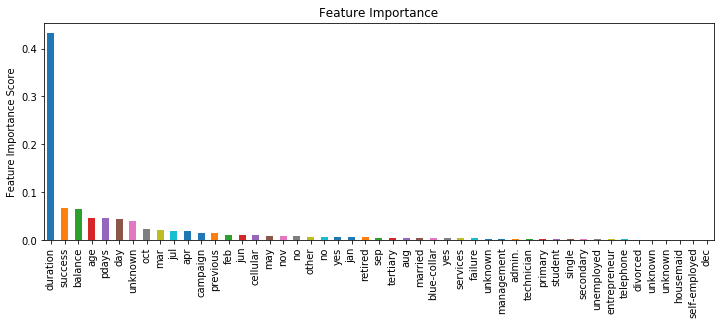

In [57]:
# Assign the test parameters i.e. # Max Features
param_grid6 = {'max_features':range(19,32,2)}
grid6 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=80,
                                                          max_depth=6,
                                                          min_samples_split=30,
                                                          min_samples_leaf=3,
                                                          subsample=0.8,
                                                          random_state=10),
                     param_grid = param_grid6,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid6.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid6.best_score_)
print('2. Parameter setting that gave the best results:', grid6.best_params_)
print('3. Estimator which gave highest score:\n', grid6.best_estimator_)

# Assign a model name to the best estimator on the train set
gbm_clf_6 = grid6.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_6"')
model_fit(gbm_clf_6, print_FeatureImportance=True)

##### GBM_CLF_7


Model Performance on Train Set
1. Mean cross-validated score (roc_auc) of the best_estimator: 0.9835363
2. Parameter setting that gave the best results: {'subsample': 0.8}
3. Estimator which gave highest score:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=29, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=30,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Performance of "glb_clf_7"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8709038
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8876241


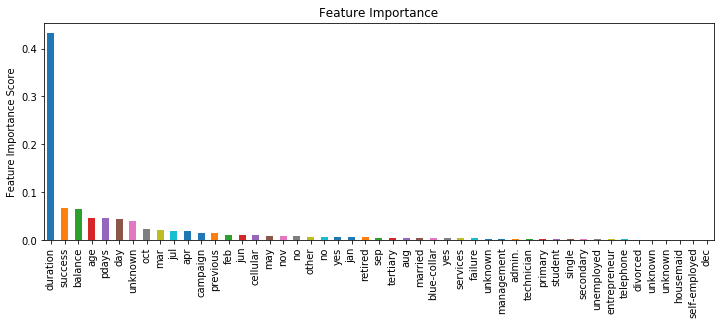

In [58]:
# Assign the test parameters i.e. # Max Features
param_grid7 = {'subsample':[0.8]}
grid7 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, 
                                                          n_estimators=80,
                                                          max_depth=6,
                                                          min_samples_split=30,
                                                          min_samples_leaf=3,
                                                          max_features=29,
                                                          random_state=10),
                     param_grid = param_grid7,
                     scoring='roc_auc',
                     n_jobs=4,
                     iid=False,
                     cv=10)
grid7.fit(X1_train_res_ros, y1_train_res_ros)

#print(grid.grid_scores_)
print('\nModel Performance on Train Set')
print('1. Mean cross-validated score (roc_auc) of the best_estimator: %.7g' % grid7.best_score_)
print('2. Parameter setting that gave the best results:', grid7.best_params_)
print('3. Estimator which gave highest score:\n', grid7.best_estimator_)

# Assign a model name to the best estimator on the train set
gbm_clf_7 = grid7.best_estimator_.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_7"')
model_fit(gbm_clf_7, print_FeatureImportance=True)

If we compare the feature importance of model **gbm_clf_7** with the **baseline model**, we see that now we are able to derive value from many more variables. Also, earlier it placed too much importance on **Duration** but now the importance has been somewhat distributed between other features.

So far, we have been able to optimize five different tree-specific hyper-parameters, which are:
1. Max Depth of a Tree  - 6
2. Min Samples at Split - 30
3. Min Samples at Leaf  - 3
4. Max Features         - 29
5. Subsample            - 0.8

We have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. Note that these trees might not be the most optimum values but a good benchmark.

Let's check the following cases, where we decrease the learning rate and increase the # Estimators (Trees)
1. Half the learning rate and double the # Estimators
2. One-tenth learning rate and ten times # Estimators

##### GBM_CLF_8

Performance of "glb_clf_8"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8633654
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8920202


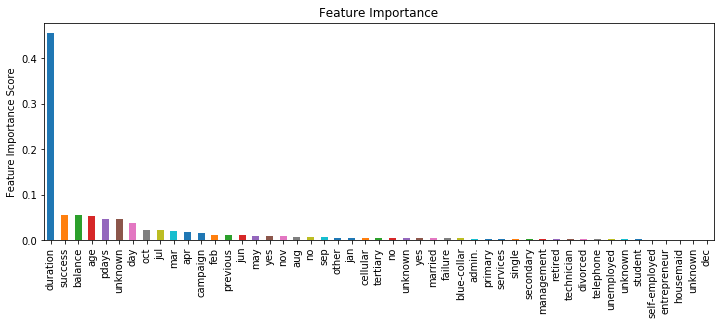

In [59]:
# Assign the test parameters i.e. Half the learning rate and double the # Estimators (Trees)
gbm8 = GradientBoostingClassifier(learning_rate=0.05,
                                  n_estimators=160,
                                  max_depth=6,
                                  min_samples_split=30,
                                  min_samples_leaf=3,
                                  max_features=29,
                                  subsample=0.8,
                                  random_state=10)
                                                          
# Assign a model name to the best estimator on the train set
gbm_clf_8 = gbm8.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_8"')
model_fit(gbm_clf_8, print_FeatureImportance=True)

##### GBM_CLF_9

Performance of "glb_clf_9"

Performance on Test Set
1. Mean cross-validated score (AUC_ROC) of the best_estimator: 0.8737756
2. Mean cross-validated score (accuracy) of the best_estimator: 0.8897014


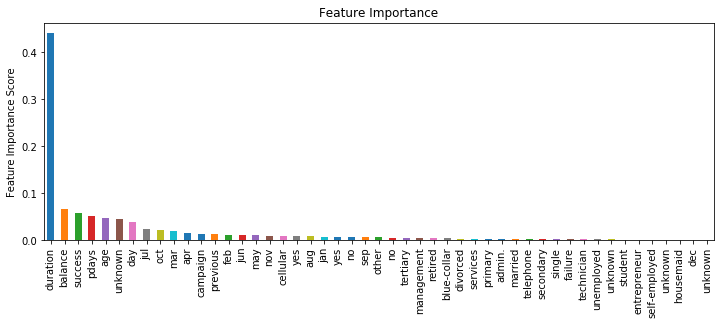

In [68]:
# Assign the test parameters i.e. 1.25 times learning rate and 0.8 times # Estimators
gbm9 = GradientBoostingClassifier(learning_rate=0.125,
                                  n_estimators=64,
                                  max_depth=6,
                                  min_samples_split=30,
                                  min_samples_leaf=3,
                                  max_features=29,
                                  subsample=0.8,
                                  random_state=10)
                                                          
# Assign a model name to the best estimator on the train set
gbm_clf_9 = gbm9.fit(X1_train_res_ros, y1_train_res_ros)

print('Performance of "glb_clf_9"')
model_fit(gbm_clf_9, print_FeatureImportance=True)

Thus having studied different gradient boosted trees classifiers, **gbm_clf_9** provides the best Mean AUC-ROC Score on test set.

GradientBoostingClassifier(criterion='friedman_mse', <br/>
                           **max_depth=6**, init=None, <br/>
                           **learning_rate=0.125**, loss='deviance', <br/>
                           **max_features=29**, max_leaf_nodes=None, <br/>
                           **min_samples_split=30**, min_impurity_decrease=0.0, <br/>
                           **min_samples_leaf=3**, min_impurity_split=None, <br/>
                           **n_estimators=64**, min_weight_fraction_leaf=0.0, <br/>
                           **subsample=0.8**,n_iter_no_change=None, presort='auto', <br/>
                           tol=0.0001, validation_fraction=0.1, random_state=10, <br/>
                           verbose=0, warm_start=False)

Model Performance on Test Set
1. Mean cross-validated score (AUC_ROC): **0.8737756**
2. Mean cross-validated score (Accuracy): 0.8897014